# Desenvolvimento e Parametrização do NSGA-II


De forma a seguir com o desenvolvimento e estudo das meta-heurísticas foi proposto para esta atividade o desenvolvimento e teste de parâmetros para uma das mais consolidadas técnicas meta-heurísticas aplicadas a problemas multiobjetivo, o Non-dominated sorting genetic algorithm II (NSGA-II).

Este algoritmo se trata de uma técnica evolucionária e populocional baseada no algoritmo genético utilizando o conceito de não dominância de pareto. De forma similar ao,já desenvolvido, algoritmo genético elitista, esta técnica ordena as soluções existentes na população pelas caracterítiscas da suas soluções (aqui a dominância de pareto), de forma que apenas uma parte da população considerada de melhor qualidade permaence iterado, ou seja, perpetuando os seus genes e mutando.

Uma das grades referências para o desenvolvimento deste trabalho foi o artigo encontrado no link:

https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf

# DTLZ1 e DTLZ2

Afim de testar e comparar a técnica em questão foram selecionadas duas funções de benchmark de largo uso para o teste de heurísticas multiobjetivo a DTLZ1 e DTLZ2.

Funções que se adaptar dinamicamente a um número de objetivos. Como exemplo podemos expressar a DTLZ1 através da fórmula:

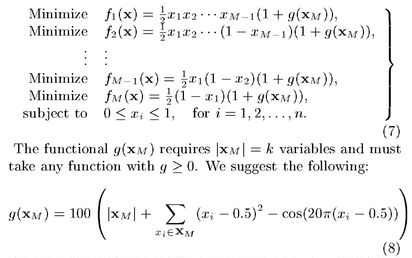

As funções DTLZ1 e DTLZ2 foram implementadas seguindo o código abaixo (após a importação das libs necessária ao desenvolvimento deste projeto).

In [1]:
import random
import math
import numpy as np
from copy import copy
import matplotlib.pyplot as plt

#Funcao de custo
def dtlz1_function(x, n_var, n_obj):
  f = []
  k = n_var - n_obj + 1

  g = 0
  i = n_var - k
  while (i < n_var):
    g = g + ((x[i] - 0.5) * (x[i] - 0.5) - (math.cos(20 * math.pi * (x[i] - 0.5))))
    i = i + 1
  
  g = 100 * (k + g)
  i = 0
  while (i < n_obj):
    v = (1.0 + g) * 0.5;
    f.append(v)
    i = i + 1

  i = 0
  j = 0
  while (i < n_obj):
    while (j < n_obj):
      f[i] = f[i] * x[j]
      j = j + 1
    if (i != 0):
      aux = n_obj - (i + 1)
      f[i] = f[i] * (1 - x[aux])
    i = i + 1

  return f

def dtlz2_function(x, n_var, n_obj):
  f = []
  k = n_var - n_obj + 1

  g = 0
  i = n_var - k
  while (i < n_var):
    g = g + ((x[i] - 0.5) * (x[i] - 0.5))
    i = i + 1
  
  i = 0
  while (i < n_obj):
    v = 1 + g;
    f.append(v)
    i = i + 1

  i = 0
  j = 0
  while (i < n_obj):
    while (j < n_obj):
      f[i] = f[i] * (math.cos(x[j] * 0.5 * math.pi));
      j = j + 1
    if (i != 0):
      aux = n_obj - (i + 1)
      f[i] = f[i] * (math.sin(x[aux] * 0.5 * math.pi))
    i = i + 1
  return f

Para fins demonstrativos podemos demonstrar a região pareto-ótima traçada para o DTLZ1 cuja implementação foi mostrada acima:

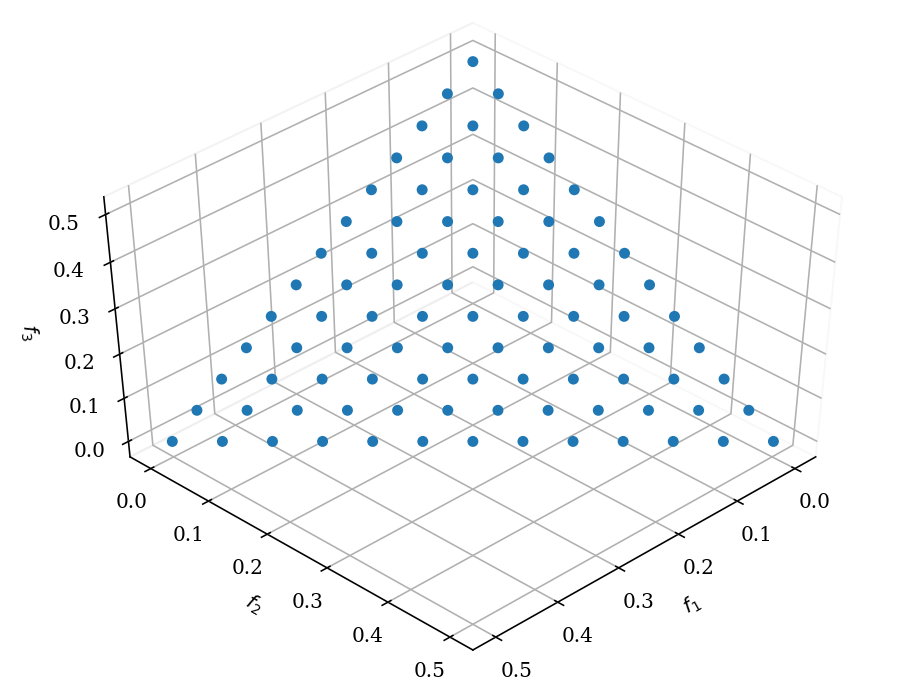

# Dominância de Pareto

Seja x1, x2 ∈ F, dizemos que x1 Pareto domina (ou, simplesmente, domina) x2 se f(x1) ≤ f(x2) e f(x1) 6= f(x2), ou seja, em pelo menos um dos objetivos a desigualdade é atendida de forma estrita. Esta relação de dominância é escrita como f(x1) ≺ f(x2) (http://www.cpdee.ufmg.br/~lusoba/disciplinas/eee910/slides/lusoba/04-dominancia.pdf).

Podemos denotar por uma ***solução eficiente*** ou ***pareto ótima*** toda aquela solução que não é dominada por nenhuma outra. O conjunto de todas as soluções não dominadas é chamado de ***conjunto eficiente*** ou ***conjunto ótimo***.

Para o desenvolvimento deste projeto foram desenvolvidas uma versão simplista da dominância de pareto e a ordenação das soluções segundo sua dominância ou não.
 

In [2]:
#Algoritmo de Dominancia de Soluções 
def dominancia_simples(sol_1, sol_2):
  domina = False
  tuplas = zip(sol_1, sol_2)
  
  for tupla_1, tupla_2 in tuplas:
    if tupla_1 < tupla_2:
        domina = True
    
    return domina 

def fronteira_pareto_simples(solucao):
    nova_lista = []
    for sol in solucao:
      nova_lista.append(sol)
      
      for sol_aux in nova_lista:
        if sol_aux != sol:
          if dominancia_simples(sol_aux.custo, sol.custo):
            nova_lista.remove(sol)
            break
          elif dominancia_simples(sol.custo, sol_aux.custo):
            nova_lista.remove(sol_aux)
    return nova_lista[0]

Seguindo a proposta do NSGA-II foi implementando então uma estratégia evolutiva e elistista que utilziará o algoritmo 8 (utilizado nas atividades anteriores) e o algoritmo 24 como estratégia de mutação e cruzamento respectivamente.

Ambos seguem codificação abaixo:

In [3]:
#Tweak proposto
def algorithm_eight(solucao, d, p, r):
    actual_sol = []
    for i in range(d):
        actual_sol.append(solucao[i])
        
    for i in range(d):
        prob = random.randrange(0, 1)
        if(prob < p):
            valor = actual_sol[i] + random.randrange(-1 * r, r)
            while (valor > 100 or valor < -100):
                valor = actual_sol[i] + random.randrange(-1 * r, r)
            actual_sol[i] = valor
            
    return actual_sol

#Crossover proposto
def algorithm_24(vetorA, vetorB, d):
    e = random.randrange(0, d)
    f = random.randrange(e, d)
    
    vetor_aux = []
    for i in range(d):
        if i <= e:
            vetor_aux.append(vetorA[i])
        if i > e and i <= f:
            vetor_aux.append(vetorB[i])
        if i > f:
            vetor_aux.append(vetorA[i])
    return vetor_aux

Definimos uma classe Solução afim de armazenar não só os os pontos da solução, como também seus valores para a posterior ordenação.

In [4]:
class Solucao:
    def __init__(self, solucao, custo):
        self.solucao = solucao
        self.custo = custo
    
    def getCusto(self):
        return self.custo
    
    def getSol(self):
        return self.solucao

# Parametrização

Aqui é feita a parametrização deste exercício, de forma a atingir a melhor solução.

Alguns destes valores foram definidos de forma estática, como o tamanho da solução (n_var = 12), o número de objetivos (n_obj = 3).

Outros foram definidos através de testes empíricos apresentados a função anterior de dominância. Ao fim destes testes chegamos aos valores do código abaixo:

In [5]:
limite = 1000
n_pop = 30
n_var = 12
n_obj = 3
n_elite = 10
v_mut = 5
v_prob = 10

Enfim partimos para a execução do código e o teste, aqui mantivemos o teste para a função DTLZ1.

In [6]:
solucao_1 = []
for j in range(n_pop):
    sol = []
    for k in range(n_var):
        number = random.randrange(-100, 100)
        sol.append(number)
    
    custo_f1 = []
    custo_f1 = dtlz2_function(sol, n_var, n_obj)
    #custo_f1 = dtlz1_function(sol, n_var, n_obj)
    
    solucao_1.append(Solucao(sol, custo_f1))    

for it in range(limite):
    
    pos_front = []
    for i in range(len(solucao_1)):
        oper_front = fronteira_pareto_simples(solucao_1)
        pos_front.append(oper_front)

    selecionado = []
    for j in range(n_elite):
        selecionado.append(copy(pos_front[j]))
        
    for j in range(n_pop-n_elite):
        pai = random.randrange(0, n_elite)
        mae = random.randrange(0, n_elite)
        children = algorithm_24(selecionado[pai].getSol(), selecionado[mae].getSol(), n_var)
        new_sol = algorithm_eight(children, n_var, v_prob, v_mut)
        #new_custo = dtlz1_function(new_sol, n_var, n_obj)
        new_custo = dtlz2_function(new_sol, n_var, n_obj)
        selecionado.append(Solucao(new_sol, new_custo))
    solucao_1 = copy(selecionado)

Afim de representar e compreender a disposição da fronteira de pareto gerada pelo código em questão foi plotado o gráfico do conjunto de soluções gerado pela execução do código acima.


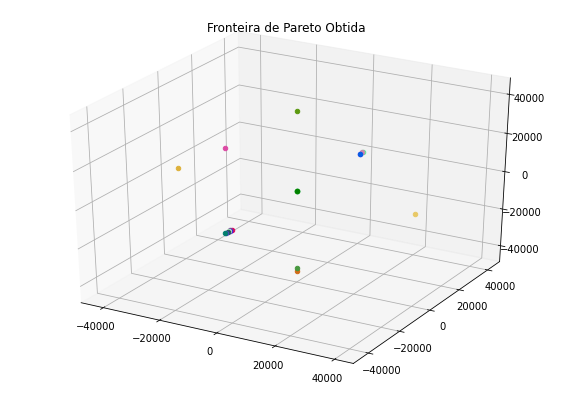

In [7]:

#Impressao dos Resultados
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
impressor = []
for i in solucao_1:
    if i.custo not in impressor:
        impressor.append(i.custo)
        ax.scatter3D(i.custo[0], i.custo[1], i.custo[2], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))

# Creating figure

 
# Creating plot
ax.scatter3D(1, 2, 3, color = "green")
plt.title("Fronteira de Pareto Obtida")
 
# show plot
plt.show()

Comparado com a região demonstrada pela imagem ao começo deste notebook podemos notar consonância na disposição dos pontos.